<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/02-pytorch-workflow-classification/torch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pytorch in depth


In [11]:
"""
cd 03-pytorch-in-depth
jupyter nbconvert --to markdown torch_workflow.ipynb --output README.md
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch  # noqa: E402
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mlxtend.plotting import plot_decision_regions

import sys

sys.path.append("..")  # Add the parent directory to the path
from global_helpers import (  # noqa: E402
    generate_blob_cluster,
    generate_xor_data,
)

## Simplifying implementations of common architectures via the torch.nn module


You have already seen some examples of building a feedforward NN model (for instance, a multilayer
perceptron) and defining a sequence of layers using the `nn.Module` class. Before we take a deeper dive
into `nn.Module`, let’s briefly look at another approach for conjuring those layers via `nn.Sequential`.


### Implementing models based on `nn.Sequential`


With `nn.Sequential` the layers stored inside the model are connected in a cascaded way.


In [142]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10, 6),
    nn.Sigmoid(),
    nn.Linear(6, 2),
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=6, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=6, out_features=2, bias=True)
)

(1000, 2) (1000,)


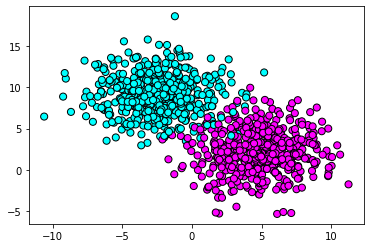

In [143]:
X_train, X_test, y_train, y_test = generate_blob_cluster(split_train_test=True)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train).float(),
    torch.tensor(X_test).float(),
    torch.tensor(y_train).float(),
    torch.tensor(y_test).float(),
)
n_train = len(X_train)

In [144]:
train_ds = TensorDataset(X_train, y_train)
batch_size = 20
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [20]:
def train(model, num_epochs, train_dl, x_valid, y_valid, log_epochs=10):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch.long())
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            is_correct = (torch.argmax(pred, axis=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train / batch_size
        accuracy_hist_train[epoch] /= n_train / batch_size

        pred = model(x_valid)
        loss = loss_fn(pred, y_valid.long())
        loss_hist_valid[epoch] = loss.item()
        is_correct = (torch.argmax(pred, axis=1) == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
        # Logging
        if epoch % log_epochs == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")
    return {
        "loss_train": loss_hist_train,
        "loss_valid": loss_hist_valid,
        "accuracy_train": accuracy_hist_train,
        "accuracy_valid": accuracy_hist_valid,
    }

In [145]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 39
history = train(model, num_epochs, train_dl, X_test, y_test, log_epochs=log_epochs)

Epoch [1/200], Loss: 0.6650936603546143
Epoch [40/200], Loss: 0.3103216886520386
Epoch [79/200], Loss: 0.12023929506540298
Epoch [118/200], Loss: 0.08938241004943848
Epoch [157/200], Loss: 0.07876066118478775
Epoch [196/200], Loss: 0.07173140347003937


Text(0.5, 0, 'Epochs')

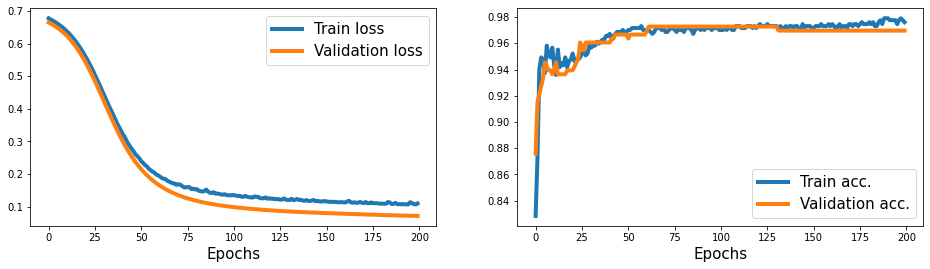

In [146]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history["loss_train"], lw=4)
plt.plot(history["loss_valid"], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history["accuracy_train"], lw=4)
plt.plot(history["accuracy_valid"], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

# plt.savefig('figures/13_03.png', dpi=300)

## Making model building more flexible with `nn.Module`


In the previous example, we used the PyTorch Sequential class to create a fully connected NN with
multiple layers. This is a very common and convenient way of building models. However, it unfortunately
doesn’t allow us to create more complex models that have multiple input, output, or intermediate
branches. That’s where `nn.Module` comes in handy.


The alternative way to build complex models is by subclassing nn.Module. In this approach, we create a
new class derived from nn.Module and define the method, `__init__()`, as a constructor. The `forward()`
method is used to specify the forward pass. In the constructor function, `__init__()`, we define the
layers as attributes of the class so that they can be accessed via the self reference attribute. Then, in
the `forward()` method, we specify how these layers are to be used in the forward pass of the NN. The
code for defining a new class that implements the previous model is as follows:


In [6]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 10)
        a1 = nn.Sigmoid()
        l2 = nn.Linear(10, 6)
        a2 = nn.Sigmoid()
        l3 = nn.Linear(6, 2)
        l = [l1, a1, l2, a2, l3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)
        return torch.argmax(pred, axis=1)

Notice that we put all layers in the nn.ModuleList object, which is just a list object composed of
nn.Module items. This makes the code more readable and easier to follow:


In [148]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=6, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=6, out_features=2, bias=True)
  )
)

**Next, besides the train history, we will use the `mlxtend` library to visualize the validation data and
the decision boundary. To compute the decision boundary of our model, we also need to add a `predict()` method in the `MyModule` class.**


In [149]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, X_test, y_test)

Epoch [1/200], Loss: 0.7060620784759521
Epoch [40/200], Loss: 0.4935990869998932
Epoch [79/200], Loss: 0.16367541253566742
Epoch [118/200], Loss: 0.09916793555021286
Epoch [157/200], Loss: 0.08117182552814484
Epoch [196/200], Loss: 0.0719602182507515


<AxesSubplot:>

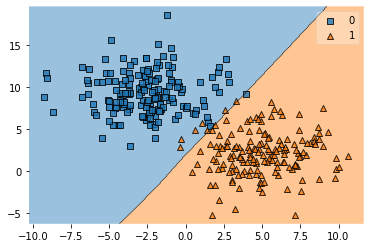

In [150]:
plot_decision_regions(X=X_test.numpy(), y=y_test.numpy().astype(np.int64), clf=model)

### example 2


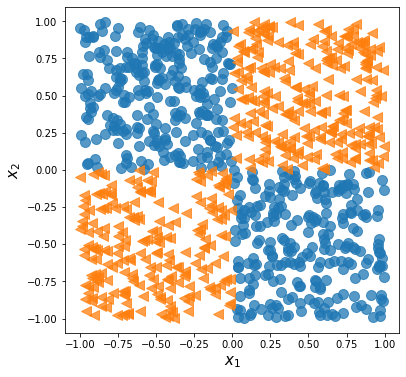

In [7]:
X_train, X_test, y_train, y_test = generate_xor_data(split_train_test=True)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train).float(),
    torch.tensor(X_test).float(),
    torch.tensor(y_train).float(),
    torch.tensor(y_test).float(),
)
n_train = len(X_train)
train_ds = TensorDataset(X_train, y_train)
batch_size = 20
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [13]:
model = MyModule()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)
# torch.manual_seed(1)
history = train(model, 100, train_dl, X_test, y_test)

Epoch [1/100], Loss: 0.6937592625617981
Epoch [11/100], Loss: 0.30175235867500305
Epoch [21/100], Loss: 0.08801449835300446
Epoch [31/100], Loss: 0.05076465755701065
Epoch [41/100], Loss: 0.04663023352622986
Epoch [51/100], Loss: 0.03594113513827324
Epoch [61/100], Loss: 0.0778207778930664
Epoch [71/100], Loss: 0.03195153549313545
Epoch [81/100], Loss: 0.035697661340236664
Epoch [91/100], Loss: 0.032447706907987595


<AxesSubplot:>

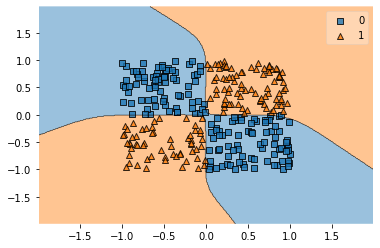

In [15]:
plot_decision_regions(X=X_test.numpy(), y=y_test.numpy().astype(np.int64), clf=model)

## Writing custom layers in PyTorch


Creating custom layers in PyTorch involves defining a class inherited from `nn.Module`. This allows us to craft our own layer functionalities. Say, we want a unique noisy linear layer that computes $w \cdot (x + \epsilon) + b$, where $\epsilon$ signifies a random variable. To do this, we create a class, typically specifying the constructor `__init__()` and the `forward()` method. The constructor sets up the necessary tensors and variables for the layer, initializing them based on given input size or postponing initialization if the input shape isn't known upfront. As an example, let's craft a layer named `NoisyLinear` to carry out the computation mentioned earlier.


In [16]:
class NoisyLinear(nn.Module):
    def __init__(self, input_features, output_features, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(output_features, input_features)
        # nn.Parameter is a Tensor that's a module parameter.
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_features).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w.t()), self.b)

    def __repr__(self):
        return (
            "NoisyLinear(in_features="
            + str(self.w.shape[1])
            + ", out_features="
            + str(self.w.shape[0])
            + ", bias="
            + str(self.b is not None)
            + ")"
        )

In [17]:
torch.manual_seed(1)

noisy_layer = NoisyLinear(input_features=2, output_features=3)

x = torch.zeros((1, 2))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))

print(noisy_layer(x, training=False))

tensor([[-0.0235,  0.0468,  0.0170]], grad_fn=<AddBackward0>)
tensor([[ 0.0144,  0.0180, -0.0422]], grad_fn=<AddBackward0>)
tensor([[0., 0., 0.]], grad_fn=<AddBackward0>)


Now, let’s create a new model similar to the previous one for solving the XOR classification task.
As before, we will use the nn.Module class for model building, but this time, we will use our
`NoisyLinear` layer as the first hidden layer of the multilayer perceptron. The code is as follows:


In [26]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 10, 0.07)
        self.a1 = nn.Sigmoid()
        self.l2 = nn.Linear(10, 6)
        self.a2 = nn.Sigmoid()
        self.l3 = nn.Linear(6, 2)

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)
        return torch.argmax(pred, axis=1)


torch.manual_seed(1)
model = MyNoisyModule()
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)
model

MyNoisyModule(
  (l1): NoisyLinear(in_features=2, out_features=10, bias=True)
  (a1): Sigmoid()
  (l2): Linear(in_features=10, out_features=6, bias=True)
  (a2): Sigmoid()
  (l3): Linear(in_features=6, out_features=2, bias=True)
)

In [27]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 39


def train(model, num_epochs, train_dl, x_valid, y_valid, log_epochs=10):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            ########! setting training=True to add noise ########
            pred = model(x_batch, training=True)
            loss = loss_fn(pred, y_batch.long())
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            is_correct = (torch.argmax(pred, axis=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train / batch_size
        accuracy_hist_train[epoch] /= n_train / batch_size

        pred = model(x_valid, training=False)
        loss = loss_fn(pred, y_valid.long())
        loss_hist_valid[epoch] = loss.item()
        is_correct = (torch.argmax(pred, axis=1) == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
        # Logging
        if epoch % log_epochs == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")
    return {
        "loss_train": loss_hist_train,
        "loss_valid": loss_hist_valid,
        "accuracy_train": accuracy_hist_train,
        "accuracy_valid": accuracy_hist_valid,
    }


history = train(
    model,
    num_epochs=num_epochs,
    train_dl=train_dl,
    x_valid=X_test,
    y_valid=y_test,
    log_epochs=log_epochs,
)

Epoch [1/200], Loss: 0.6921265125274658
Epoch [40/200], Loss: 0.10089663416147232
Epoch [79/200], Loss: 0.07622559368610382
Epoch [118/200], Loss: 0.06156187877058983
Epoch [157/200], Loss: 0.05972304567694664
Epoch [196/200], Loss: 0.06177102401852608


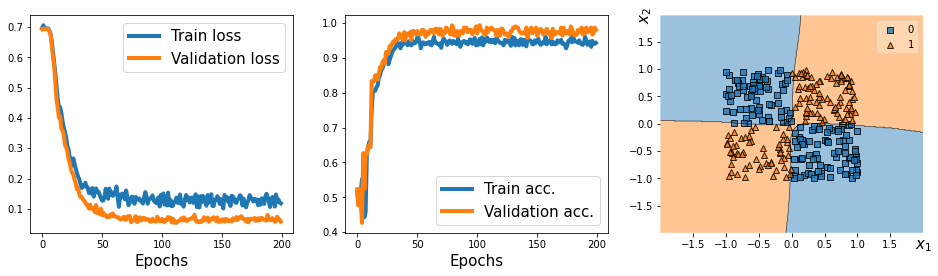

In [29]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history["loss_train"], lw=4)
plt.plot(history["loss_valid"], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history["accuracy_train"], lw=4)
plt.plot(history["accuracy_valid"], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=X_test.numpy(), y=y_test.numpy().astype(np.int64), clf=model)
ax.set_xlabel(r"$x_1$", size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r"$x_2$", size=15)
ax.yaxis.set_label_coords(-0.025, 1)

# plt.savefig('figures/13_06.png', dpi=300)
plt.show()

## Project one – Linear Regression


In this section, we will work on a real-world project of predicting the fuel efficiency of a car in miles per gallon (MPG). We will cover the underlying steps in machine learning tasks, such as data preprocessing, feature engineering, training, prediction (inference), and evaluation.


### Data preprocessing, feature engineering


In [3]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]

df = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


Partitioning the dataset into training and test datasets


In [5]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
Model Year,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


Standardizing the continuous features


In [6]:
numeric_column_names = [
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
]
df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

scaler = StandardScaler()
df_train_norm[numeric_column_names] = scaler.fit_transform(
    df_train[numeric_column_names]
)
df_test_norm[numeric_column_names] = scaler.transform(df_test[numeric_column_names])

df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.825623,-0.902462,-0.737741,-0.951552,0.255611,76,3
255,19.4,0.351689,0.414463,-0.341528,0.293660,0.549616,78,1
72,13.0,1.529001,1.146088,0.715040,1.341762,-0.626404,72,1
235,30.5,-0.825623,-0.892707,-1.054711,-1.074303,0.476114,77,1
37,14.0,1.529001,1.565553,1.639537,1.472775,-1.361417,71,1


Next, let’s group the rather fine-grained model year (ModelYear) information into buckets to simplify
the learning task for the model that we are going to train later. Concretely, we are going to assign each
car into one of four year buckets, as follows:

$$
\text{bucket} = \begin{cases}
0 & \text{if } \text{year} < 73 \\
1 & \text{if } 73 \leq \text{year} < 76 \\
2 & \text{if } 76 \leq \text{year} < 79 \\
3 & \text{if } \text{year} \geq 79 \\
\end{cases}
$$


In order to group the cars into these buckets, we will first define three cut-off values: `[73, 76, 79]` for the
model year feature. These cut-off values are used to specify half-closed intervals, for instance, `(–∞, 73),
[73, 76), [76, 79), and [76, ∞)`. Then, the original numeric features will be passed to the
[`torch.bucketize`](https://pytorch.org/docs/stable/generated/torch.bucketize.html) function to generate the
indices of the buckets


In [7]:
boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm["Model Year"].values)
df_train_norm["Model Year Bucketed"] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm["Model Year"].values)
df_test_norm["Model Year Bucketed"] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append("Model Year Bucketed")

Next, we will proceed with defining a list for the unordered categorical feature, **Origin**. In PyTorch,
**There are two ways to work with a categorical feature**: using an embedding layer via `nn.Embedding`
(https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), or using `one-hot-encoded`
vectors (also called indicator).

In the encoding approach, for example, index 0 will be encoded as [1, 0, 0], index 1 will be encoded as [0, 1, 0], and so on. On the other hand, the embedding layer maps each index to a vector of random numbers of the type float, which can be trained. (You can think of the embedding layer as a more efficient implementation of a one-hot encoding multiplied with a trainable weight matrix.)

When the number of categories is large, using the embedding layer with fewer dimensions than the
number of categories can improve the performance.

We will use the one-hot-encoding approach on the categorical feature in order to convert it into the dense format


In [8]:
classes = df_train_norm["Origin"].unique()
print(classes)

[1 2 3]


In [9]:
F.one_hot(torch.from_numpy(classes), num_classes=3)

RuntimeError: Class values must be smaller than num_classes.

In [10]:
print(classes)
print(classes % len(classes))
F.one_hot(torch.from_numpy(classes % len(classes)), num_classes=3)
# The number of classes will be inferred as one greater than the largest class value in the input tensor if 'num_classes' is not given.

[1 2 3]
[1 2 0]


tensor([[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]])

In [11]:
total_origin = len(df_train_norm["Origin"].unique())
origin_encoded_train = F.one_hot(
    torch.from_numpy(df_train_norm["Origin"].values) % total_origin
)
origin_encoded_test = F.one_hot(
    torch.from_numpy(df_test_norm["Origin"].values) % total_origin
)

In [12]:
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded_train], 1).float()
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded_test], 1).float()

y_train = torch.tensor(df_train_norm["MPG"].values).float()
y_test = torch.tensor(df_test_norm["MPG"].values).float()

In [13]:
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

### Training a DNN regression model


In [70]:
torch.manual_seed(1)

input_features = x_train.shape[1]
hidden_units = [10, 6, 4]

all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_features, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_features = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model

Sequential(
  (0): Linear(in_features=9, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=6, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6, out_features=4, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=1, bias=True)
)

In [71]:
num_epochs = 200
log_epochs = 20

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        optimizer.zero_grad()
        pred = model(x_batch).squeeze(1)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        loss_hist_train += loss.item()
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch}  Loss {loss_hist_train/len(train_dl):.4f}")

Epoch 0  Loss 504.8686
Epoch 20  Loss 8.2171
Epoch 40  Loss 7.8521
Epoch 60  Loss 7.9645
Epoch 80  Loss 7.7267
Epoch 100  Loss 8.3547
Epoch 120  Loss 6.4928
Epoch 140  Loss 6.9542
Epoch 160  Loss 6.6513
Epoch 180  Loss 6.4105


In [72]:
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f"Test MSE: {loss.item():.4f}")
    print(f"Test MAE: {nn.L1Loss()(pred, y_test).item():.4f}")

Test MSE: 15.7344
Test MAE: 2.9747


## Project two : classifying MNIST hand-written digits


In [3]:
from datasets import load_dataset

dataset = load_dataset("mnist")

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist downloaded and prepared to C:/Users/soiko/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
dataset["test"]["image"][0]

In [84]:
from torchvision import transforms
from datasets import load_dataset
from torch.utils.data import random_split, DataLoader

# https://huggingface.co/docs/datasets/v1.11.0/splits.html
# Load the MNIST dataset
train_ds, test_ds = load_dataset("mnist", split=["train[:1000]", "test[:200]"])
print(train_ds, test_ds)

Found cached dataset mnist (C:/Users/soiko/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
}) Dataset({
    features: ['image', 'label'],
    num_rows: 200
})


In [232]:
train_ds.set_format(type="torch", columns=["image", "label"])
test_ds.set_format(type="torch", columns=["image", "label"])
print(type(train_ds[0]["image"]))  # This should output <class 'torch.Tensor'>

# Extract tensors for testing
x_train = train_ds["image"].float()
y_train = train_ds["label"].long()

x_test = test_ds["image"].float()
y_test = test_ds["label"].long()

<class 'torch.Tensor'>


In [137]:
train_ds[0]["image"].dtype

torch.uint8

> Note!! PyTorch initialzie linear layer by default float32 as the dtype. So input should also be float() or will get the `RuntimeError: mat1 and mat2 must have the same dtype`


In [233]:
# Create a DataLoader
batch_size = 20
t = TensorDataset(x_train, y_train)
train_dl = DataLoader(t, batch_size=batch_size, shuffle=True)

In [234]:
train_ds[0]["image"].shape

torch.Size([28, 28])

In [227]:
def make_model():
    hidden_units = [32, 16]
    image_size = train_ds[0]["image"].shape
    input_size = image_size[0] * image_size[1]
    input_size = image_size[0] * image_size[1]
    all_layers = [nn.Flatten()]

    for hidden_unit in hidden_units:
        layer = nn.Linear(input_size, hidden_unit)
        all_layers.append(layer)
        all_layers.append(nn.ReLU())
        input_size = hidden_unit

    all_layers.append(nn.Linear(hidden_units[-1], 10))
    return nn.Sequential(*all_layers)


model = make_model()
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [185]:
print(model[1].weight.dtype)

torch.float32


In [302]:
def plot_train_valid_history(history):
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["loss_train"], lw=4)
    ax.plot(history["loss_valid"], lw=4)
    ax.legend(["Train loss", "Validation loss"], fontsize=15)
    ax.set_xlabel("Epochs", size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["accuracy_train"], lw=4)
    ax.plot(history["accuracy_valid"], lw=4)
    ax.legend(["Train acc.", "Validation acc."], fontsize=15)
    ax.set_xlabel("Epochs", size=15)
    plt.show()

In [312]:
# https://github.com/rasbt/machine-learning-book/blob/main/ch13/ch13_part1.py


def train_model(
    model,
    num_epochs,
    train_dl,
    x_valid,
    y_valid,
    optimizer,
    loss_fn,
    scheduler=None,
    log_epochs=10,
    early_stop=30,
):
    # Define accuracy function
    def accuracy(logits, targets):
        predicted_labels = torch.argmax(logits, dim=1)
        return (predicted_labels == targets).float().mean()

    best_valid_loss = float("inf")
    early_stop_counter = 0

    history = {
        "loss_train": [],
        "loss_valid": [],
        "accuracy_train": [],
        "accuracy_valid": [],
    }

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        model.train()

        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            # accumulate batch-wise for current epoch
            train_loss += loss.item()
            train_acc += accuracy(pred, y_batch)

        # avg loss, acc
        train_loss /= len(train_dl)
        train_acc /= len(train_dl)
        # Here, len(train_dl) = len(train_dl.dataset) / train_dl.batch_size
        history["loss_train"].append(train_loss)
        history["accuracy_train"].append(train_acc)

        model.eval()
        with torch.no_grad():
            pred_valid = model(x_valid)
            valid_loss = loss_fn(pred_valid, y_valid)
            valid_acc = accuracy(pred_valid, y_valid)
            history["loss_valid"].append(valid_loss.item())
            history["accuracy_valid"].append(valid_acc)

            if scheduler:
                scheduler.step(valid_loss)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                # Save the model checkpoint
                # torch.save(model.state_dict(), "best_model.pth")
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if early_stop_counter >= early_stop:
                print("Early stopping triggered!")
                break

        if epoch % log_epochs == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
            )

    return history


# Usage Example:
torch.manual_seed(1)
model = make_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", patience=10, factor=0.1, verbose=True
)
loss_fn = nn.CrossEntropyLoss()

history = train_model(
    model,
    num_epochs=200,
    train_dl=train_dl,
    x_valid=x_test,
    y_valid=y_test,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
)

Epoch [1/200], Train Loss: 2.1428, Train Acc: 0.3970, Valid Loss: 1.4248, Valid Acc: 0.5750
Epoch [11/200], Train Loss: 0.0533, Train Acc: 0.9850, Valid Loss: 0.5256, Valid Acc: 0.8650
Epoch [21/200], Train Loss: 0.0023, Train Acc: 1.0000, Valid Loss: 0.6143, Valid Acc: 0.8700
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
Epoch [31/200], Train Loss: 0.0015, Train Acc: 1.0000, Valid Loss: 0.6277, Valid Acc: 0.8650
Epoch 00034: reducing learning rate of group 0 to 1.0000e-05.
Epoch [41/200], Train Loss: 0.0015, Train Acc: 1.0000, Valid Loss: 0.6287, Valid Acc: 0.8650
Early stopping triggered!


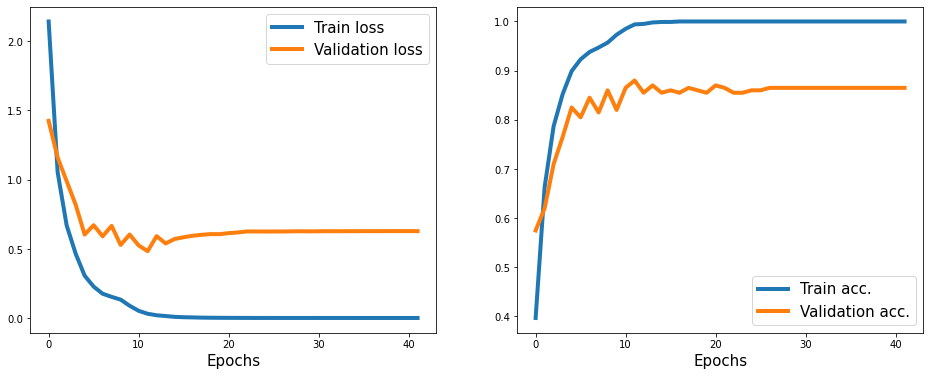

In [313]:
plot_train_valid_history(history=history)